# RO reference
Fit RO on observations to get "ground truth" behavior

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats

# Import custom modules
import src.XRO
import src.XRO_utils
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Load data

In [2]:
## specify filepaths
oras_fp = DATA_FP / "oras5"
sst_fp = oras_fp / "tos_control_monthly_highres_2D_1958-2020_CONS_v0.1.nc"
ssh_fp = oras_fp / "ssh_control_monthly_highres_2D_1958-2020_CONS_v0.1_global.nc"

## load data
data = src.utils.load_oras_spatial(sst_fp, ssh_fp, extended_record=True)

## compute indices
idx = src.utils.get_RO_indices(data)

## Detrend / pre-process

In [3]:
## estimate forced signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=3)
idx_anom = idx.groupby("time.month").map(detrend_fn)
idx_forced = idx - idx_anom

## Cross correlation stats

Plotting function

In [4]:
def format_xcorr_ax(ax):
    """make xcorr plot look nice"""

    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)
    ax.set_ylim([-0.7, 1.1])
    ax.set_xlabel("Lag (years)")
    ax.set_xticks([-24, -12, 0, 12, 24], labels=[-2, -1, 0, 1, 2])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel("Correlation")
    return

Make the plot

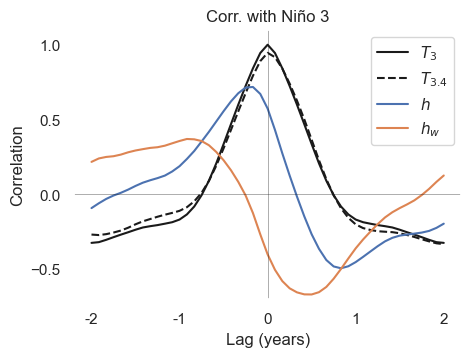

In [5]:
## compute cross-corr
xcorr = src.XRO.xcorr(idx_anom, idx_anom["T_3"], maxlags=24)

## plot result
fig, ax = plt.subplots(figsize=(5, 3.5))

## plot data
ax.plot(xcorr.lag, xcorr["T_3"], label=r"$T_3$", c="k")
ax.plot(xcorr.lag, xcorr["T_34"], label=r"$T_{3.4}$", c="k", ls="--")
ax.plot(xcorr.lag, xcorr["h"], label=r"$h$")
ax.plot(xcorr.lag, xcorr["h_w"], label=r"$h_w$")

## format plot
ax.set_title("Corr. with Niño 3")
ax.legend()
format_xcorr_ax(ax)

plt.show()

## Fit RO models

In [6]:
## specify order of annual cycle, mask parameters
ac_order = 3
ac_mask_idx = [(1, 1)]  # epsilon
# ac_mask_idx = [(1,0), (1, 1)] # epsilon and F2
# ac_mask_idx = [(0,1),(1,0),(1, 1)] # all except R
# ac_mask_idx = None

## initialize model
model = src.XRO.XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit_h = model.fit_matrix(idx_anom[["T_34", "h"]], ac_mask_idx=ac_mask_idx)
fit_hw = model.fit_matrix(idx_anom[["T_3", "h_w"]], ac_mask_idx=ac_mask_idx)

## extract params
p_h = model.get_RO_parameters(fit_h)
p_hw = model.get_RO_parameters(fit_hw)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


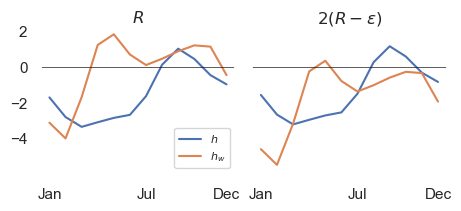

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2), layout="constrained")

for i, (ax, n) in enumerate(zip(axs, ["R", "BJ_ac"])):
    ax.plot(p_h.cycle, p_h[n], label=r"$h$")
    ax.plot(p_hw.cycle, p_hw[n], label=r"$h_w$")

    ## format
    ax.axhline(0, ls="-", c="k", lw=0.5)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])

## label
axs[1].set_yticks([])
axs[0].set_yticks([-4, -2, 0, 2])
axs[0].set_title(r"$R$")
axs[1].set_title(r"$2\left(R-\varepsilon\right)$")
axs[0].legend(prop=dict(size=8))
axs[0].set_ylim([-6, 2])
axs[1].set_ylim(0.5 * np.array(axs[0].get_ylim()))

plt.show()